In [1]:
# set seeds to ensure repeatability of results
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)

import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize


# Don't Show Warning Messages
import warnings
#warnings.filterwarnings('ignore')

In [2]:
!python --version

Python 3.11.9


In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

PADDING = 40

NUM_TEST_IMAGES = 10

## Introduction

In this kernel our goal is to build a computer vision model that can look at a mask of a micropscope slide and predict how many cells are present.

This is a link to a web interface where a similar model has been deployed. You can submit jpg mask images and get an automatic cell count. Please use the Chrome browser for best results.<br>
http://cellcount.test.woza.work/

This site can be used to convert images from TIF to jpg format.<br>
https://tiff2jpg.com/




In [34]:
# ==============================
# Make a List of Test Set Masks
# ==============================

#pd.set_option('display.max_rows', None)

test_list = os.listdir('./BBBC005_v1_images/BBBC005_v1_images/')
test_list = pd.DataFrame(test_list, columns=['image_id'])
test_list = test_list[test_list['image_id'] != '.htaccess']

mask_list = os.listdir('./BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/')
mask_list = pd.DataFrame(mask_list, columns=['image_id'])
mask_list = mask_list[mask_list['image_id'] != '.htaccess']
test_list = test_list[~test_list['image_id'].isin(mask_list['image_id'])]
test_list = test_list.reset_index(drop=True)

def get_num_cells(x):
    a = x.split('_')
    b = a[2]
    num_cells = int(b[1:])
    return num_cells

def get_stain(x):
    a = x.split('_')
    b = a[5].split('.')
    stain = int(b[0][1])
    return stain

test_list['num_cells'] = test_list['image_id'].apply(get_num_cells)
test_list['stain'] = test_list['image_id'].apply(get_stain)

#For cell body stain (W1)
#test_list = test_list[test_list['stain'] == 1]
#For nuclei stain (W2)
#test_list = test_list[test_list['stain'] == 2]

test_list = test_list.reset_index(drop=True)

X_test = np.zeros((len(test_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

for i in tqdm(range(test_list.shape[0]-1)):
    path_mask = './BBBC005_v1_images/BBBC005_v1_images/' + test_list['image_id'][i+1]
    cv2_image = cv2.imread(path_mask)

    cv2_image = cv2.resize(cv2_image, (IMG_HEIGHT, IMG_WIDTH))
    cv2.imwrite('mask.jpg', cv2_image)
    mask = imread('mask.jpg')
    X_test[i] = mask

test_id_list = test_list['image_id']
test_id_list = test_id_list.to_list()
num_cells = test_list['num_cells']
num_cells = num_cells.to_list()

100%|██████████████████████████████████████████████████████████████████████████████| 8999/8999 [04:23<00:00, 34.11it/s]


<hr>

## Put all info into a dataframe

In [5]:
# get a list of files in each folder

img_list = os.listdir('./BBBC005_v1_images/BBBC005_v1_images')
mask_list = os.listdir('./BBBC005_v1_ground_truth/BBBC005_v1_ground_truth')

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

# filter out the non image file that's called .htaccess
df_images = df_images[df_images['image_id'] != '.htaccess']



# Example file name: SIMCEPImages_A13_C53_F1_s23_w2.TIF


# ======================================================
# Add a column showing how many cells are on each image
# ======================================================

def get_num_cells(x):
    # split on the _
    a = x.split('_')
    # choose the third item
    b = a[2] # e.g. C53
    # choose second item onwards and convert to int
    num_cells = int(b[1:])

    return num_cells

# create a new column called 'num_cells'
df_images['num_cells'] = df_images['image_id'].apply(get_num_cells)


# ================================================
# Add a column indicating if an image has a mask.
# ================================================

# Keep in mind images and masks have the same file names.

def check_for_mask(x):
    if x in mask_list:
        return 'yes'
    else:
        return 'no'

# create a new column called 'has_mask'
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)



# ===========================================================
# Add a column showing how much blur was added to each image
# ===========================================================

def get_blur_amt(x):
    # split on the _
    a = x.split('_')
    # choose the third item
    b = a[3] # e.g. F1
    # choose second item onwards and convert to int
    blur_amt = int(b[1:])

    return blur_amt

# create a new column called 'blur_amt'
df_images['blur_amt'] = df_images['image_id'].apply(get_blur_amt)


In [6]:
df_images.head()

,image_id,num_cells,has_mask,blur_amt
1,SIMCEPImages_A01_C1_F1_s01_w1.TIF,1,yes,1
2,SIMCEPImages_A01_C1_F1_s01_w2.TIF,1,yes,1
3,SIMCEPImages_A01_C1_F1_s02_w1.TIF,1,yes,1
4,SIMCEPImages_A01_C1_F1_s02_w2.TIF,1,yes,1
5,SIMCEPImages_A01_C1_F1_s03_w1.TIF,1,yes,1


## Create a df containing only masks

In [7]:
df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = df_masks['image_id']

df_masks.shape

C:\Users\riann\AppData\Local\Temp\ipykernel_448\2329185241.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_masks['mask_id'] = df_masks['image_id']


(1200, 5)

In [8]:
df_masks.head()

,image_id,num_cells,has_mask,blur_amt,mask_id
1,SIMCEPImages_A01_C1_F1_s01_w1.TIF,1,yes,1,SIMCEPImages_A01_C1_F1_s01_w1.TIF
2,SIMCEPImages_A01_C1_F1_s01_w2.TIF,1,yes,1,SIMCEPImages_A01_C1_F1_s01_w2.TIF
3,SIMCEPImages_A01_C1_F1_s02_w1.TIF,1,yes,1,SIMCEPImages_A01_C1_F1_s02_w1.TIF
4,SIMCEPImages_A01_C1_F1_s02_w2.TIF,1,yes,1,SIMCEPImages_A01_C1_F1_s02_w2.TIF
5,SIMCEPImages_A01_C1_F1_s03_w1.TIF,1,yes,1,SIMCEPImages_A01_C1_F1_s03_w1.TIF


## Create df_test

In [9]:

# test_id_list and num_cells were defined in the introduction section.
df_test = pd.DataFrame(test_id_list, columns=['mask_id'])

# add a new column with the number of cells on each mask
df_test['num_cells'] = num_cells

# Reset the index.
# This is so that we can use loc to access mask id's later.
df_test = df_test.reset_index(drop=True)


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_masks = df_masks[~df_masks['mask_id'].isin(test_id_list)]

print(df_masks.shape)
print(df_test.shape)

(1200, 5)
(18000, 2)


In [10]:
df_test.head(10)

,mask_id,num_cells
0,SIMCEPImages_B01_C1_F4_s01_w1.TIF,1
1,SIMCEPImages_B01_C1_F4_s01_w2.TIF,1
2,SIMCEPImages_B01_C1_F4_s02_w1.TIF,1
3,SIMCEPImages_B01_C1_F4_s02_w2.TIF,1
4,SIMCEPImages_B01_C1_F4_s03_w1.TIF,1
5,SIMCEPImages_B01_C1_F4_s03_w2.TIF,1
6,SIMCEPImages_B01_C1_F4_s04_w1.TIF,1
7,SIMCEPImages_B01_C1_F4_s04_w2.TIF,1
8,SIMCEPImages_B01_C1_F4_s05_w1.TIF,1
9,SIMCEPImages_B01_C1_F4_s05_w2.TIF,1


## Define X_train and y_train

In [11]:
# X_train

# Get lists of images and their masks.
mask_id_list = list(df_masks['mask_id'])

# Create empty arrays
X_train = np.zeros((len(mask_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) #, dtype=np.bool)


for i, mask_id in enumerate(mask_id_list):

    path_mask = './BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/' + mask_id

    # read the file as an array
    cv2_image = cv2.imread(path_mask)
    # resize the image
    cv2_image = cv2.resize(cv2_image, (IMG_HEIGHT, IMG_WIDTH))
    # save the image at the destination as a jpg file
    cv2.imwrite('mask.jpg', cv2_image)

    # read the image using skimage
    mask = imread('mask.jpg')

    # resize the image
    #mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    #mask = np.expand_dims(mask, axis=-1)

    # insert the image into X_Train
    X_train[i] = mask



# y_train

y_train = df_masks['num_cells'] #.astype(np.float16)



In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(1200, 128, 128, 3)
(1200,)
(18000, 128, 128, 3)


In [13]:
X_train[1, :, :, :].shape

(128, 128, 3)

## Model Architecture

In [14]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()

# Input layer for rgb image. For grayscale image use the same channel 3 times
# to maintain the shape that the model requires.
model.add(Conv2D(first_filters, kernel_size, activation = 'relu',
                 input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))

model.add(ZeroPadding2D(padding=(PADDING, PADDING), data_format=None))

model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())

model.add(Dense(1024))
model.add(LeakyReLU())
model.add(BatchNormalization())

model.add(Dense(512))
model.add(LeakyReLU())
model.add(BatchNormalization())

model.add(Dense(1, activation='relu')) # set activation='relu' to keep all values positive

model.summary()

C:\Users\riann\anaconda3\envs\AI_FP\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 206, 206, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 204, 204, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 202, 202, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 101, 101, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 101, 101, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 99, 99, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 97, 97, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 95, 95, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 47, 47, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 47, 47, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 43, 43, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,878,529 (30.05 MB)

 Trainable params: 7,875,457 (30.04 MB)

 Non-trainable params: 3,072 (12.00 KB)

## Train the Model

In [15]:
model.compile(Adam(learning_rate=0.001), loss='mean_squared_error',
              metrics=['mean_squared_error'])

filepath = "model.keras"

earlystopper = EarlyStopping(patience=15, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_mean_squared_error', verbose=1,
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=100,
                    callbacks=callbacks_list)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1439.1989 - mean_squared_error: 1439.1989
Epoch 1: val_mean_squared_error improved from inf to 1173708.37500, saving model to model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 1432.9568 - mean_squared_error: 1432.9568 - val_loss: 1173708.3750 - val_mean_squared_error: 1173708.3750
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 505.2079 - mean_squared_error: 505.2079
Epoch 2: val_mean_squared_error did not improve from 1173708.37500
68/68 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - loss: 504.5757 - mean_squared_error: 504.5757 - val_loss: 2528300.2500 - val_mean_squared_error: 2528300.2500
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 402.6716 - mean_squared_error: 402.6716
Epoch 3: val_mean_squared_error improved from 1173708.37500 to 423.72696, saving model to model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - loss: 402.1564 - mean_squared_error: 402.1564 - val_loss: 423.7270 - val_mean_squared_error

## Plot the Training Curves

<Figure size 640x480 with 0 Axes>

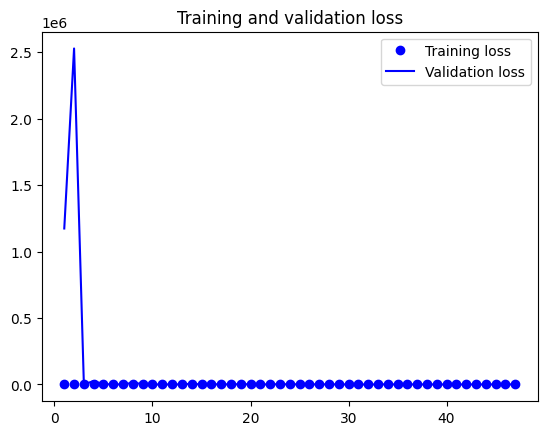

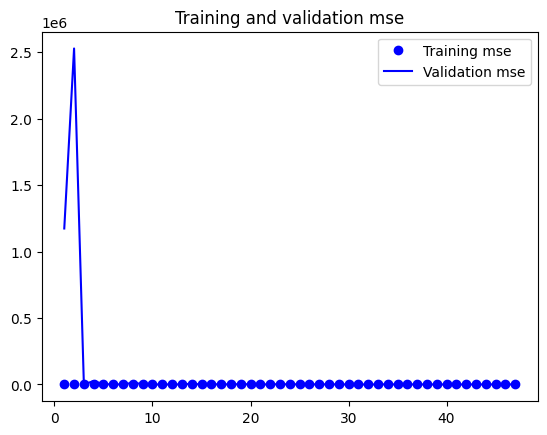

<Figure size 640x480 with 0 Axes>

In [16]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

mean_squared_error = history.history['mean_squared_error']
val_mean_squared_error = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mean_squared_error) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, mean_squared_error, 'bo', label='Training mse')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.figure()

## Make a Prediction

In [17]:
# use the best epoch
model.load_weights('model.keras')

preds = model.predict(X_test)


563/563 ━━━━━━━━━━━━━━━━━━━━ 655s 1s/step


In [18]:
preds

array([[ 1.5313612],
       [ 0.       ],
       [ 0.       ],
       ...,
       [ 7.7515454],
       [37.631813 ],
       [ 1.573574 ]], dtype=float32)

In [19]:
# add the preds to df_test
df_test['preds'] = np.round(preds)

# change the preds to integers to improve the look of the displayed results
df_test['preds'] = df_test['preds'].apply(int)

# create a dataframe caled df_results
df_results = df_test[['mask_id', 'num_cells', 'preds']]

# add a new column with the difference between the true and predicted values.
df_results['difference'] = abs(df_results['num_cells'] - df_results['preds'])


### What were the max and min errors?

In [20]:
df_results.head(18000)

,mask_id,num_cells,preds,difference
0,SIMCEPImages_B01_C1_F4_s01_w1.TIF,1,2,1
1,SIMCEPImages_B01_C1_F4_s01_w2.TIF,1,0,1
2,SIMCEPImages_B01_C1_F4_s02_w1.TIF,1,0,1
3,SIMCEPImages_B01_C1_F4_s02_w2.TIF,1,1,0
4,SIMCEPImages_B01_C1_F4_s03_w1.TIF,1,1,0
...,...,...,...,...
17995,SIMCEPImages_P24_C100_F48_s23_w2.TIF,100,7,93
17996,SIMCEPImages_P24_C100_F48_s24_w1.TIF,100,36,64
17997,SIMCEPImages_P24_C100_F48_s24_w2.TIF,100,8,92
17998,SIMCEPImages_P24_C100_F48_s25_w1.TIF,100,38,62


In [21]:
# What was the max difference?

max_diff = df_results['difference'].max()
min_diff = df_results['difference'].min()

print('Max Error: ', max_diff)
print('Min Error: ', min_diff)

Max Error:  99
Min Error:  0


In [22]:
tolerance = 0.3

image_num = df_results['difference'].size

TP = 0

for i in range(image_num):
    if df_results['difference'][i] < tolerance * df_results['num_cells']:
        TP = TP + 1

accuracy = TP / image_num

print('The accuracy is: ', accuracy)

The accuracy is:  0.06388888888888888


## Convert the Model to Tensorflow.js

In [23]:
# --ignore-installed is added to fix an error.

# https://stackoverflow.com/questions/49932759/pip-10-and-apt-how-to-avoid-cannot-uninstall
# -x-errors-for-distutils-packages

!pip install tensorflowjs --ignore-installed

  Using cached tensorflowjs-4.19.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached flax-0.8.3-py3-none-any.whl.metadata (10 kB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached jax-0.4.28-py3-none-any.whl.metadata (23 kB)
  Using cached jaxlib-0.4.28-cp311-cp311-win_amd64.whl.metadata (1.8 kB)
  Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
  Using cached tf_keras-2.16.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached tensorflow_decision_forests-1.8.1-cp311-cp311-win_amd64.whl
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached packaging-23.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached msgpack-1.0.8-cp311-cp311-win_amd64.whl.metadata (9.4 kB)
  Using cached optax-0.2.2-py3-none-any.whl.metadata (8.1 kB)
  Using cached orbax_checkpoint

ERROR: Could not install packages due to an OSError: [WinError 5] 存取被拒。: 'C:\\Users\\riann\\anaconda3\\envs\\AI_FP\\Lib\\site-packages\\wrapt\\_wrappers.cp311-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [24]:
# Use the command line conversion tool to convert the model

!tensorflowjs_converter --input_format keras model.h5 tfjs/model

'tensorflowjs_converter' 不是內部或外部命令、可執行的程式或批次檔。


In [25]:
# check that the folder containing the tfjs model files has been created
!ls

'ls' 不是內部或外部命令、可執行的程式或批次檔。


## Conclusion

We see that the results are unexpectedly good. Who would have thought that a simple cnn could perform this well. With only 1,190 training images it appears that it is in fact possible to build a cell counting model that produces good results.

You will notice that the model has a padding layer. Padding the images helped to improve the model's performance. This could be because padding helped the model to detect cells that are located at the edges of the masks.

Intuitively one would think that to improve the model's performance we need to add more images that look like paint splashes. Surprisingly, while doing different experiments, I saw that the model found it easier to analyze paint splash images and images with a large number of cells. It struggled a bit with images that showed a few individual cells. Therefore, one preliminary conclusion is that, in order to improve model performance, we need to add more images showing just a few individual cells (about 1 to 14 cells).

It's important to take note that the results are different each time this kernel is run. This could be because Keras uses a different validation set each time. Therefore, it's advisable to perform 5 fold cross validation to get a more confident estimate of this models performance.

Thank you for reading.